In [51]:
from petsc4py import PETSc
from mpi4py import MPI
import ufl
from dolfinx import mesh, fem
from dolfinx.fem.petsc import assemble_matrix, assemble_vector, apply_lifting, create_vector, set_bc
import numpy as np
t = 0  # Start time
T = 1  # End time
num_steps = 100  # Number of time steps
dt = (T - t) / num_steps  # Time step size

In [52]:
nx, ny = 100,100
domain = mesh.create_unit_square(MPI.COMM_WORLD, nx, ny, mesh.CellType.triangle)
domain = mesh.create_rectangle(comm=MPI.COMM_WORLD,
                            points=((0.0, 0.0), (np.pi, np.pi)), n=(nx, ny),
                            cell_type=mesh.CellType.triangle)
V = fem.FunctionSpace(domain, ("Lagrange", 1))

In [53]:
class exact_solution():
    def __init__(self,  t):
        self.t = t
    def __call__(self, x):
        return np.exp(-self.t)*np.sin(x[0])*np.sin(x[1])

In [54]:
u_exact = exact_solution(t)
u_D = fem.Function(V)
u_D.interpolate(u_exact)
tdim = domain.topology.dim
fdim = tdim - 1
domain.topology.create_connectivity(fdim, tdim)
boundary_facets = mesh.exterior_facet_indices(domain.topology)
bc = fem.dirichletbc(u_D, fem.locate_dofs_topological(V, fdim, boundary_facets))

In [55]:
u_n = fem.Function(V)
u_n.interpolate(u_exact)

In [56]:
u, v = ufl.TrialFunction(V), ufl.TestFunction(V)
F = u * v * ufl.dx + 1/2* dt * ufl.dot(ufl.grad(u), ufl.grad(v)) * ufl.dx - (u_n) * v * ufl.dx
a = fem.form(ufl.lhs(F))
L = fem.form(ufl.rhs(F))

In [57]:
A = assemble_matrix(a, bcs=[bc])
A.assemble()
b = create_vector(L)
uh = fem.Function(V)

In [58]:
solver = PETSc.KSP().create(domain.comm)
solver.setOperators(A)
solver.setType(PETSc.KSP.Type.PREONLY)
solver.getPC().setType(PETSc.PC.Type.LU)

In [59]:
for n in range(num_steps):
    # Update Diriclet boundary condition
    u_exact.t += dt
    u_D.interpolate(u_exact)

    # Update the right hand side reusing the initial vector
    with b.localForm() as loc_b:
        loc_b.set(0)
    assemble_vector(b, L)

    # Apply Dirichlet boundary condition to the vector
    apply_lifting(b, [a], [[bc]])
    b.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
    set_bc(b, [bc])

    # Solve linear problem
    solver.solve(b, uh.vector)
    uh.x.scatter_forward()

    # Update solution at previous time step (u_n)
    u_n.x.array[:] = uh.x.array

In [60]:
# Compute L2 error and error at nodes
V_ex = fem.FunctionSpace(domain, ("Lagrange", 2))
u_ex = fem.Function(V_ex)
u_ex.interpolate(u_exact)
error_L2 = np.sqrt(domain.comm.allreduce(fem.assemble_scalar(fem.form((uh - u_ex)**2 * ufl.dx)), op=MPI.SUM))
if domain.comm.rank == 0:
    print(f"L2-error: {error_L2:.2e}")

# Compute values at mesh vertices
error_max = domain.comm.allreduce(np.max(np.abs(uh.x.array - u_D.x.array)), op=MPI.MAX)
if domain.comm.rank == 0:
    print(f"Error_max: {error_max:.2e}")

L2-error: 2.64e-03
Error_max: 1.74e-03


In [61]:
from dolfinx import io, plot
with io.XDMFFile(domain.comm, "out_poisson/poisson.xdmf", "w") as file:
    file.write_mesh(domain)
    file.write_function(uh)


No module named 'trame'

Falling back to a static output.
  warnings.warn(



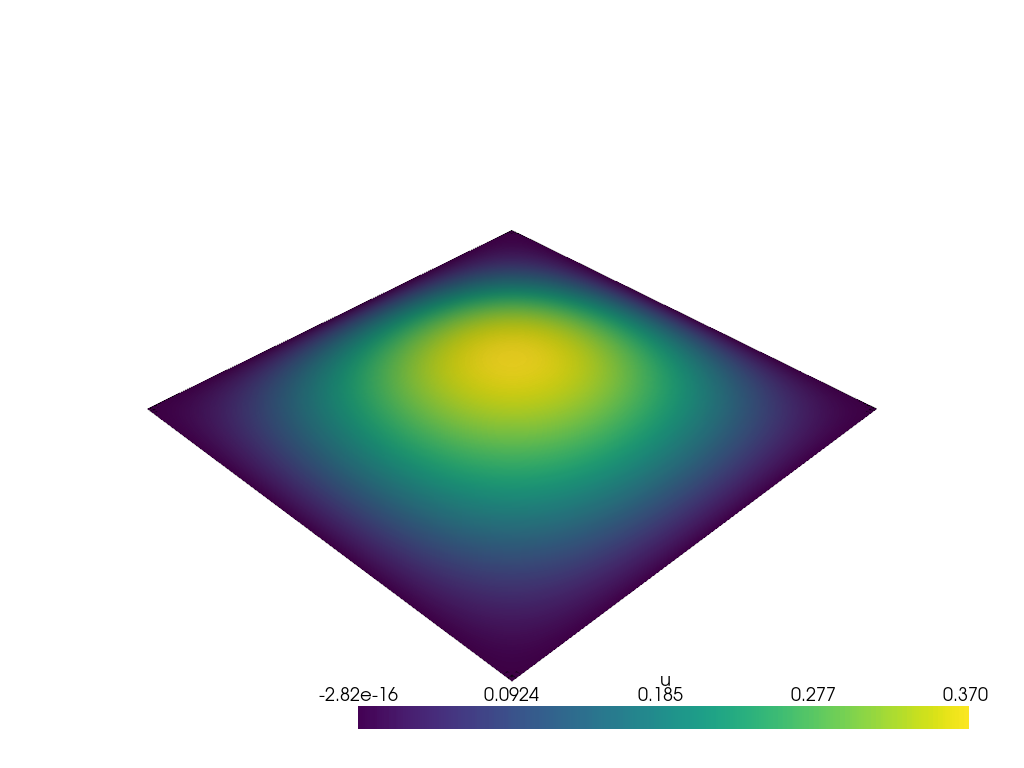

In [62]:
try:
    import pyvista
    cells, types, x = plot.vtk_mesh(V)
    grid = pyvista.UnstructuredGrid(cells, types, x)
    grid.point_data["u"] = uh.x.array.real
    grid.set_active_scalars("u")
    plotter = pyvista.Plotter()
    plotter.add_mesh(grid, show_edges=True)
    warped = grid.warp_by_scalar()
    plotter.add_mesh(warped)
    if pyvista.OFF_SCREEN:
        pyvista.start_xvfb(wait=0.1)
        plotter.screenshot("uh_poisson.png")
    else:
        plotter.show()
except ModuleNotFoundError:
    print("'pyvista' is required to visualise the solution")
    print("Install 'pyvista' with pip: 'python3 -m pip install pyvista'")


No module named 'trame'

Falling back to a static output.
  warnings.warn(



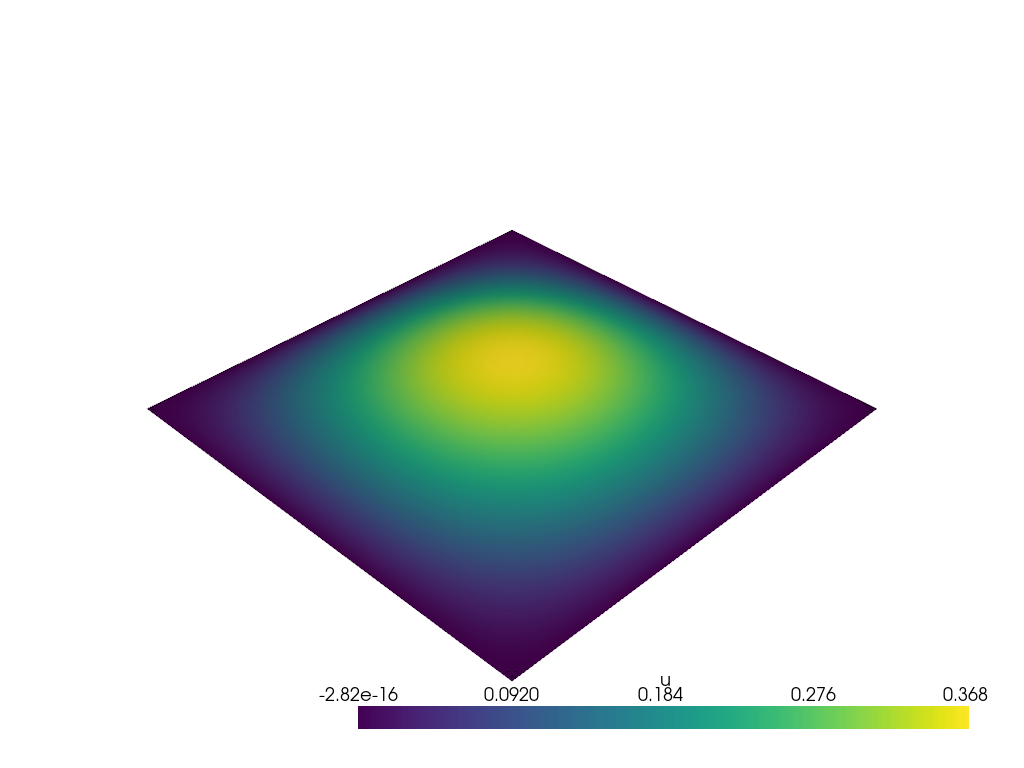

In [63]:
try:
    import pyvista
    cells, types, x = plot.vtk_mesh(V)
    grid = pyvista.UnstructuredGrid(cells, types, x)
    grid.point_data["u"] = u_D.x.array.real
    grid.set_active_scalars("u")
    plotter = pyvista.Plotter()
    plotter.add_mesh(grid, show_edges=True)
    warped = grid.warp_by_scalar()
    plotter.add_mesh(warped)
    if pyvista.OFF_SCREEN:
        pyvista.start_xvfb(wait=0.1)
        plotter.screenshot("uh_poisson.png")
    else:
        plotter.show()
except ModuleNotFoundError:
    print("'pyvista' is required to visualise the solution")
    print("Install 'pyvista' with pip: 'python3 -m pip install pyvista'")